# Tutorial: Graph Coloring with (quantum) column generation algorithm

## Reduced Master Problem (RMP) and Column Generation Algorithms 

The Reduced Master Problem is an algorithm introduced by Wesley da Silva Coelho et al. [2301.02637](https://arxiv.org/abs/2301.02637) as a quantum-enhanced column generation method. Their quantum-classical hybrid algorithm are especially suitable for solving combinatorial optimization problems using neutral atom quantum computers. 

Column generation itself is an iterative optimization methodology designed to tackle linear programming problems with an overwhelmingly large number of variables, often referred to as "columns." In such cases, considering all variables explicitly becomes computationally infeasible. The RMP is a constrained version of the original problem, formulated using only a limited subset of these variables. This restriction is not a limitation, but rather the key to the column generation approach. By starting with a manageable set of columns, the algorithm iteratively approaches a solution for problems with a prohibitively large number of potential options. The RMP serves two primary functions: it provides the current best solution given the available columns and generates dual variables that guide the search for new, beneficial columns in a related sub-problem called the Pricing Sub-Problem (PSP). The interaction between the RMP and the PSP is cyclical and forms the core of the column generation process. The RMP is solved; the dual variables from its solution are passed to the PSP; the PSP attempts to generate new columns that would improve the RMP's objective function. If found, these new columns are added to the RMP, and the process repeats.

In the initial formulation of the RMP, we begin with a subset of variables, denoted as S', that must guarantee a feasible solution to the RMP. This initial feasibility is crucial for the algorithm to proceed. In the context of MVCP, where columns represent independent sets of vertices, a trivial but effective way to build the initial set S' is to include only the singletons, where each vertex is an independent set of size one. This ensures that every vertex has a color assigned, providing a feasible starting point for the optimization. Mathematically, the RMP for MVCP can be formulated with the objective of minimizing the number of selected independent sets, represented by the equation:

$$\min \sum_{s \in S'} y_s $$

This aims to minimize the total number of colors used. The constraints ensure that every vertex 'u' in the graph's vertex set 'V' is covered by exactly one selected independent set from S':

$$\sum_{s \in S'} b_{us} y_s = 1, \quad \forall u \in V $$

Here, $b_{us}$ is a binary parameter that equals 1 if vertex 'u' is in independent set 's', and 0 otherwise. During the iterative phase, the variables $y_s$, which indicate whether independent set 's' is chosen, are relaxed to be continuous between 0 and 1:

$$0 \leq y_s \leq 1, \quad \forall s \in S' $$

In each iteration of the column generation procedure, the RMP, as defined by equations (9)-(11), is solved in its linear relaxation form, typically by a classical linear programming (LP) solver. Solving the RMP as a linear relaxation is a crucial choice that allows for the extraction of dual variables from the LP solution. These dual variables are essential for guiding the PSP. Dual variables, denoted as $w_u$, represent the economic incentive for satisfying the constraints of the RMP. For MVCP, the PSP is often formulated as a Maximum Weighted Independent Set (MWIS) problem. The objective of this MWIS problem is to find an independent set $s^*$ that maximizes the sum of the dual variables of its constituent vertices:

$$\max \sum_{u \in V} (w_u \cdot x_u) $$

where $x_u$ is 1 if vertex 'u' is in the independent set and 0 otherwise. The reduced cost $r_s$ of a potential new column (independent set 's') is calculated as:

$$r_s = 1 - \sum_{u \in V} (w_u \cdot x_u) $$

A new column is deemed beneficial if its reduced cost is negative ($r_s < 0$), which is equivalent to the sum of the dual variables for the vertices in the independent set being greater than 1.

If the PSP identifies one or more beneficial independent sets, these are added as new columns to the RMP's set of active variables S', and the RMP is resolved. This iterative loop continues until the PSP cannot find any new columns with a negative reduced cost, indicating that the current RMP solution is optimal for the available columns. At this point, the integrality constraints on the $y_s$ variables are re-imposed ($y_s \in \{0, 1\}$), and the RMP is solved as an Integer Linear Program (ILP) to obtain the final integer solution. This solution is optimal with respect to the generated set S', but not necessarily the global optimum. In the hybrid quantum-classical framework, the RMP itself is solved using a classical solver, while the PSP, which often involves solving an NP-hard problem like MWIS, can leverage quantum computation for potential speedup or better solutions. This approach aims to combine the strengths of both classical and quantum computing paradigms, applying quantum resources specifically to the most challenging part of the algorithm.




## Classical Column Generation Solver

Let's first demonstrate the algorithm and workflow with classical solvers (with scipy linear programming solver `linprog` and mixed-integer LP solver `milp`)

In [1]:
import numpy as np
from scipy.optimize import linprog, milp, OptimizeWarning
from scipy.sparse import lil_matrix
from collections import namedtuple
import warnings
import networkx as nx
import matplotlib.pyplot as plt

# Suppress warnings from linprog/milp if they are too verbose for a tutorial
warnings.filterwarnings("ignore", category=OptimizeWarning)

In [2]:
def solve_mvcp_column_generation(G, graph_name="Graph"):
    """
    Solves the Minimum Vertex Coloring Problem (MVCP) using classical column generation.
    """
    num_vertices = G.number_of_nodes()
    original_nodes = sorted(list(G.nodes()))
    node_to_idx = {node: i for i, node in enumerate(original_nodes)}
    mapped_edges = [(node_to_idx[u], node_to_idx[v]) for u, v in G.edges()]
    edges = mapped_edges

    print(f"Solving MVCP for a graph with {num_vertices} vertices and {len(edges)} edges.")

    # 2. Initialization
    current_columns = [frozenset([i]) for i in range(num_vertices)]
    known_column_signatures = {tuple(sorted(list(s))) for s in current_columns}

    print(f"Initial columns (singleton independent sets): {current_columns}\\n")

    max_iterations = 20
    iteration = 0
    tolerance = 1e-6

    # Column generation loop
    while iteration < max_iterations:
        iteration += 1
        print(f"--- Iteration {iteration} ---")

        # 3. Solve Reduced Master Problem (RMP)
        num_columns = len(current_columns)
        num_constraints = num_vertices

        # Constraint matrix: A[u, s] = 1 if vertex u is in independent set s
        A = lil_matrix((num_constraints, num_columns))
        for s_idx, independent_set in enumerate(current_columns):
            for vertex in independent_set:
                A[vertex, s_idx] = 1

        A = A.tocsc()  # Convert to compressed sparse column format for efficiency

        # RHS: each vertex must be covered exactly once
        b = np.ones(num_constraints)

        # Objective: minimize sum of y_s (number of colors)
        c = np.ones(num_columns)

        # Bounds: 0 <= y_s <= 1
        bounds = [(0, 1) for _ in range(num_columns)]

        print(f"  Solving RMP with {num_columns} columns...")
        rmp_result = linprog(c, A_eq=A, b_eq=b, bounds=bounds, method='highs')

        if not rmp_result.success:
            print(f"  RMP failed: {rmp_result.message}")
            break

        print(f"  RMP Objective (sum of y_s, LP relaxed): {rmp_result.fun:.4f}")

        # Extract dual variables
        dual_vars = rmp_result.eqlin.marginals
        print(f"  Dual variables (weights for PSP): {dual_vars}")

        # 4. Solve Pricing Subproblem (PSP) - Maximum Weighted Independent Set
        print(f"  Solving PSP (MWIS) to find a new column...")

        # Use exact MILP formulation for MWIS (matches original implementation)
        c_psp = -np.array(dual_vars)  # Maximize dual weights (minimize negative)
        integrality_psp = np.ones(num_vertices, dtype=int)
        bounds_psp = ([0] * num_vertices, [1] * num_vertices)

        # Edge constraints: for each edge, at most one endpoint can be selected
        num_edges = len(edges)
        A_ub_psp = lil_matrix((num_edges, num_vertices), dtype=float)
        for i, edge in enumerate(edges):
            A_ub_psp[i, edge[0]] = 1
            A_ub_psp[i, edge[1]] = 1
        b_ub_psp = np.ones(num_edges)

        from scipy.optimize import LinearConstraint, Bounds
        psp_constraints = [LinearConstraint(A_ub_psp.toarray(), -np.inf, b_ub_psp)]
        psp_result = milp(c=c_psp, constraints=psp_constraints, integrality=integrality_psp, bounds=bounds_psp)

        if not psp_result.success:
            print(f"  PSP failed: {psp_result.message}")
            break

        new_independent_set_indices = [v for v, val in enumerate(psp_result.x) if val > 0.5]
        new_independent_set = set(new_independent_set_indices)
        psp_objective = -psp_result.fun  # Convert back from minimization
        print(f"  PSP found new potential independent set: {new_independent_set}")
        print(f"  PSP objective value (sum of duals for this set): {psp_objective:.4f}")

        # Check if the new column improves the solution (reduced cost < 0)
        reduced_cost = 1 - psp_objective
        if reduced_cost >= -tolerance:
            print(f"\\n  No more profitable columns found (PSP objective {psp_objective:.4f} <= 1). Stopping column generation.\\n")
            break

        # Add new column if it's beneficial and not already known
        new_column_signature = tuple(sorted(list(new_independent_set)))
        if new_column_signature not in known_column_signatures:
            current_columns.append(frozenset(new_independent_set))
            known_column_signatures.add(new_column_signature)
            print(f"  Adding new column: {new_independent_set}. Total columns: {len(current_columns)}")
        else:
            print(f"  Column {new_independent_set} already exists. Stopping.")
            break

    # 5. Solve final integer problem
    print("\\n--- Solving Final RMP as Integer Linear Program ---\\n")

    final_num_columns = len(current_columns)
    final_A = lil_matrix((num_constraints, final_num_columns))
    for s_idx, independent_set in enumerate(current_columns):
        for vertex in independent_set:
            final_A[vertex, s_idx] = 1

    final_A = final_A.tocsc()
    final_c = np.ones(final_num_columns)
    final_b = np.ones(num_constraints)

    # Integer constraints: y_s \in {0, 1}
    integrality = np.ones(final_num_columns, dtype=int)  # 1 = integer variable

    constraints = LinearConstraint(final_A, final_b, final_b)
    bounds = Bounds(lb=0, ub=1)
    
    final_rmp_result = milp(c=final_c, integrality=integrality, constraints=constraints, bounds=bounds)

    if final_rmp_result.success:
        num_colors = int(round(final_rmp_result.fun))
        print(f"Minimum number of colors found: {num_colors}")
        print("Selected Independent Sets (Colors):")
        color_idx_for_print = 0
        for i, y_val in enumerate(final_rmp_result.x):
            if y_val > 0.5:
                selected_set = set(current_columns[i])
                print(f"  - Color {color_idx_for_print + 1}: {selected_set}")
                color_idx_for_print += 1
        print("Verification: All vertices are covered by exactly one color.\\n")
    else:
        print(f"Final RMP failed: {final_rmp_result.message}")

    # Build coloring solution list (same format as quantum solver)
    coloring_solution_list = []
    if final_rmp_result.success:
        for i, y_val in enumerate(final_rmp_result.x):
            if y_val > 0.5:  # Column is selected
                # current_columns[i] contains mapped indices, convert to original node labels
                original_color_set = {original_nodes[node_idx] for node_idx in current_columns[i]}
                coloring_solution_list.append(frozenset(original_color_set))

    return final_rmp_result, current_columns, coloring_solution_list



Some Plotting Utilities

In [3]:
def plot_graph(graph, title="Graph", node_colors=None, pos=None):
    """
    Plots the graph using networkx and matplotlib.
    If node_colors is provided, it should be a list or array of colors
    corresponding to the nodes in G.nodes().
    """
    if pos is None:
        pos = nx.spring_layout(graph, seed=42) # for consistent layout

    plt.figure(figsize=(8, 6))

    if node_colors:
        # Ensure node_colors is a list if it's a dict mapping nodes to colors
        if isinstance(node_colors, dict):
            color_map = [node_colors.get(node, 'lightgray') for node in graph.nodes()]
        else:
            color_map = node_colors
        nx.draw(graph, pos, with_labels=True, node_color=color_map, node_size=700, font_size=10, font_weight='bold', edge_color='gray')
    else:
        nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=700, font_size=10, font_weight='bold', edge_color='gray')

    plt.title(title)
    plt.show()


def plot_classical_cg_solution(G, final_result, current_columns, coloring_solution_list, num_colors, graph_name="Graph"):
    """
    Plot the classical column generation solution results.
    
    Args:
        G: NetworkX graph (original)
        final_result: MILP result object
        current_columns: List of column sets (mapped indices)
        coloring_solution_list: List of color sets (original node labels)
        num_colors: Number of colors found
        graph_name: Name for plot title
    """
    # Store a layout for consistent plotting
    graph_layout = nx.spring_layout(G, seed=42)
    
    if final_result and final_result.success:
        # Create coloring mapping for visualization
        final_coloring_map = {}
        plot_color_palette = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink', 'teal', 'lavender', 'brown', 'beige', 'maroon']
        
        # Map each vertex to its color for plotting
        for color_idx, color_set in enumerate(coloring_solution_list):
            for node in color_set:
                final_coloring_map[node] = plot_color_palette[color_idx % len(plot_color_palette)]
        
        # Plot graph with coloring
        plot_graph(G, title=f"{graph_name} - Final Coloring: {num_colors} colors", node_colors=final_coloring_map, pos=graph_layout)
    else:
        # Plot graph without coloring if solution failed
        plot_graph(G, title=f"{graph_name} - Solution Failed", pos=graph_layout)

### Examples

Running MVCP solver for Graph 1 (5-vertex example)...
Solving MVCP for a graph with 5 vertices and 6 edges.
Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4})]\n
--- Iteration 1 ---
  Solving RMP with 5 columns...
  RMP Objective (sum of y_s, LP relaxed): 5.0000
  Dual variables (weights for PSP): [1. 1. 1. 1. 1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 3}
  PSP objective value (sum of duals for this set): 2.0000
  Adding new column: {0, 3}. Total columns: 6
--- Iteration 2 ---
  Solving RMP with 6 columns...
  RMP Objective (sum of y_s, LP relaxed): 4.0000
  Dual variables (weights for PSP): [ 1.  1.  1. -0.  1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 4}
  PSP objective value (sum of duals for this set): 2.0000
  Adding new column: {0, 4}. Total columns: 7
--- Iteration 3 ---
  Solving RMP with 7 columns...


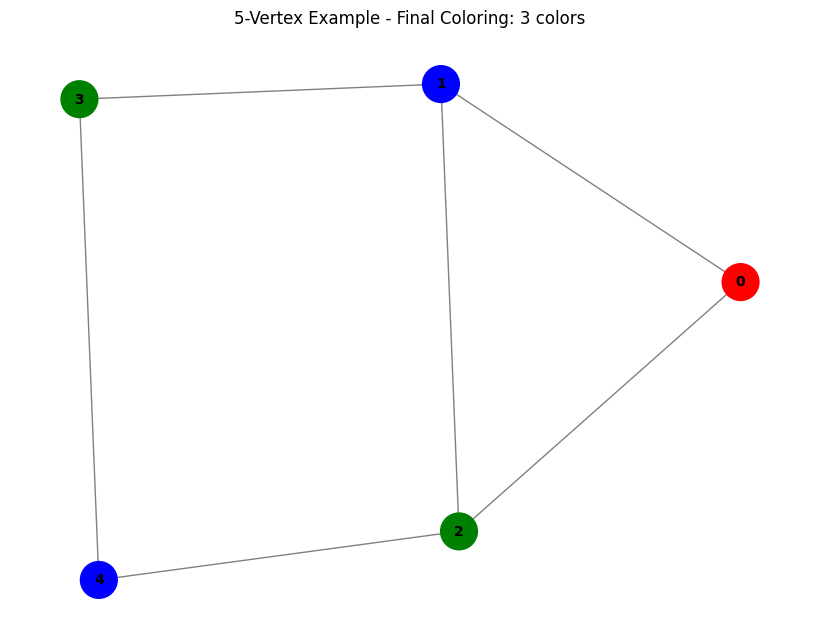

In [4]:
# Example 1: The 5-vertex graph from the paper
G1 = nx.Graph()
G1.add_nodes_from(range(5)) # Nodes 0, 1, 2, 3, 4
G1.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
print("Running MVCP solver for Graph 1 (5-vertex example)...")
result1, columns1, classical_coloring1 = solve_mvcp_column_generation(G1, graph_name="5-Vertex Example")

print("\n\n" + "="*50 + "\n\n")

print("\n--- Summary for Graph 1 (5-Vertex Example) ---")
if result1 and result1.success: # Check if result1 is not None
    print(f"Final number of colors: {int(round(result1.fun))}")
    print(f"Total columns generated: {len(columns1)}")
    # Plot the classical solution
    plot_classical_cg_solution(G1, result1, columns1, classical_coloring1, int(round(result1.fun)), "5-Vertex Example")
elif result1:
    print(f"MVCP solution was not successful for Graph 1. Message: {result1.message}")
    # Plot failed solution
    plot_classical_cg_solution(G1, result1, columns1, classical_coloring1, 0, "5-Vertex Example") 
else:
    print("MVCP solution process for Graph 1 did not complete to produce a result object.")

Running MVCP solver for Graph 2 (Random 9-Vertex Graph, p=0.4)...
Solving MVCP for a graph with 9 vertices and 16 edges.
Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8})]\n
--- Iteration 1 ---
  Solving RMP with 9 columns...
  RMP Objective (sum of y_s, LP relaxed): 9.0000
  Dual variables (weights for PSP): [1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {8, 1, 2, 5}
  PSP objective value (sum of duals for this set): 4.0000
  Adding new column: {8, 1, 2, 5}. Total columns: 10
--- Iteration 2 ---
  Solving RMP with 10 columns...
  RMP Objective (sum of y_s, LP relaxed): 6.0000
  Dual variables (weights for PSP): [ 1.  1.  1.  1.  1.  1.  1.  1. -2.]
  Solving PSP (MWIS) to find a new column...
  PSP found new potential independent set: {0, 5, 6, 7}
  PSP objective value (sum of d

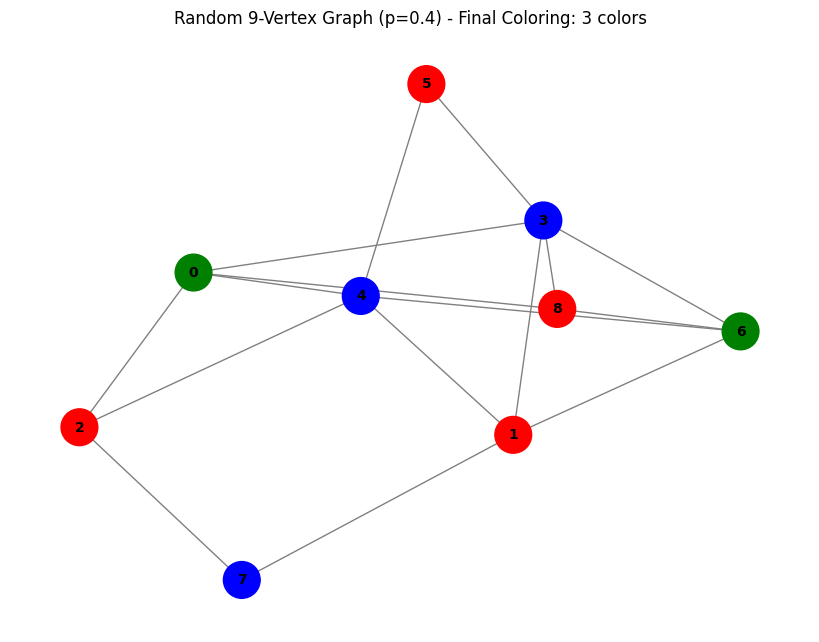

In [5]:
# Example 2: Random Graph (Erdos-Renyi)
num_random_nodes = 9
prob_edge = 0.4
seed_random = 42 # For reproducibility
G2 = nx.gnp_random_graph(num_random_nodes, prob_edge, seed=seed_random)
# Ensure G2 nodes are 0-indexed for simplicity with current mapping, gnp_random_graph does this.
print(f"Running MVCP solver for Graph 2 (Random {num_random_nodes}-Vertex Graph, p={prob_edge})...")
result2, columns2, classical_coloring2 = solve_mvcp_column_generation(G2, graph_name=f"Random {num_random_nodes}-Vertex (p={prob_edge})")

print("\n--- Summary for Graph 2 (Random Graph) ---")
if result2 and result2.success: # Check if result2 is not None
    print(f"Final number of colors: {int(round(result2.fun))}")
    print(f"Total columns generated: {len(columns2)}")
    # Plot the classical solution
    plot_classical_cg_solution(G2, result2, columns2, classical_coloring2, int(round(result2.fun)), f"Random {num_random_nodes}-Vertex Graph (p={prob_edge})")
elif result2:
    print(f"MVCP solution was not successful for Graph 2. Message: {result2.message}")
    # Plot failed solution
    plot_classical_cg_solution(G2, result2, columns2, classical_coloring2, 0, f"Random {num_random_nodes}-Vertex Graph (p={prob_edge})")
else:
    print("MVCP solution process for Graph 2 did not complete to produce a result object.")

## Quantum Column Generation Solver

Great ! But how could (Neutral Atom) Quantum Computers help ?

#### Neutral Atom Quantum Computers

Neutral atom arrays have emerged as a highly promising platform for quantum computation and simulation. In these systems, individual neutral atoms are trapped using optical tweezers, allowing for precise arrangement in 1D, 2D, or even 3D geometries. Quantum information is typically encoded in two electronic states of each atom: a ground state $|g\rangle$ and a highly excited Rydberg state $|r\rangle$. Lasers are used to drive transitions between these states ($\Omega$) and control their energy difference (detuning $\delta$).

A key feature is the strong, long-range interaction between atoms in the Rydberg state ($|r\rangle$). This interaction falls off rapidly with distance $R$ (typically as $C_6/R^6$).

#### The Blockade Mechanism

The strong Rydberg interaction leads to the **Rydberg blockade** effect: if one atom is excited to $|r\rangle$, the energy levels of nearby atoms are shifted significantly, preventing them from being resonantly excited to $|r\rangle$ by the same laser field. This blockade occurs within a characteristic radius $R_b$.

Effectively, this means that only atoms separated by a distance greater than $R_b$ can be simultaneously excited to the Rydberg state. This naturally implements the constraint of an **Independent Set** on a graph where atoms are vertices and edges connect atoms closer than $R_b$. Such a graph, where connectivity is determined solely by distance, is known as a **Unit-Disk Graph (UDG)**.


#### Using `maximum-independent-set` package
The `maximum-independent-set` package provide us a high-level api to solve the maximum independent set problems with neutral atom quantum computers/emulators. 

Below we customize a simple embedder `MyEmbedder` to just scaled the original locations. Notice that the default embedder usually rearrange the atom position (hopefully a UDG but not always doable) in order to solve the MIS problem more efficiently.


In [6]:
import warnings
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import linprog, milp, OptimizeWarning, LinearConstraint
from scipy.sparse import lil_matrix

# Imports for the 'mis' package
from mis import MISInstance, MISSolver, BackendConfig, BackendType
from mis.pipeline.config import SolverConfig
from mis.pipeline.pulse import BasePulseShaper
from mis.pipeline.embedder import BaseEmbedder
from mis.shared.types import MethodType # For solver methods like EAGER
from mis.data.dataloader import DataLoader
from mis.coloring.coloring import GraphColoringSolver

# Suppress verbose warnings from the solver and deprecated features if any
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Debug and Visualization Section

This section demonstrates how to configure, test, and visualize the quantum MIS solver settings including the atom embedding and pulse sequences. This is useful for understanding how the quantum algorithm maps the graph problem onto the physical quantum device.

### Embedder

In order to solve a MIS instance on a neutral atom quantum computer, we need to encode the graph structure to the arrangment of atom locations inside the hardware. Below we rescale the original graph position so that the minimum node distance satisfies the hardware constraint: $d >$ `device.min_atom_distance`. But we also record the maximum node separation, in order to calculuate an adaquate **blockade radius**

In [7]:
import pulser
from mis.pipeline.pulse import Register, Pulse


def center_positions(positions):
    """Center node positions around centroid for better embedder compatibility."""
    all_coords = np.stack(list(positions.values()))
    centroid = np.mean(all_coords, axis=0)
    centered_positions = {node: pos - centroid for node, pos in positions.items()}
    return centered_positions


class MyEmbedder(BaseEmbedder):
    """
    Fixed embedder with proper coordinate preservation and scaling.
    
    This implementation:
    1. Preserves original antenna coordinates when available
    2. Centers positions around centroid for better embedding
    3. Scales to respect minimum atom distance constraints
    4. Stores scaling information for pulse shaper compatibility
    """

    def embed(self, instance: MISInstance, config: SolverConfig, backend) -> Register:
        device = backend.device()
        assert device is not None

        # Layout based on node positions
        positions = nx.get_node_attributes(instance.graph, 'pos')
        if not positions:
            # Use spring layout if no positions available
            positions = nx.spring_layout(instance.graph, iterations=100)
        positions = {k: np.array(v) for k, v in positions.items()}
        
        if len(positions) > 1:
            positions = center_positions(positions)

        # Rescale to ensure that minimal distances are respected
        distances = [
            np.linalg.norm(positions[v1] - positions[v2])
            for v1 in instance.graph.nodes()
            for v2 in instance.graph.nodes()
            if v1 != v2
        ]
        
        multiplier = 1.0  # Default multiplier when no scaling needed
        max_distance_scaled = device.min_atom_distance  # Default fallback
        
        if len(distances) != 0:
            min_distance = np.min(distances)
            max_distance = np.max(distances)
            
            if min_distance < device.min_atom_distance:
                multiplier = device.min_atom_distance / min_distance
                positions = {i: v * multiplier for (i, v) in positions.items()}
            
            # Calculate maximum distance after scaling for blockade radius
            max_distance_scaled = max_distance * multiplier
        
        # Store both the scaling multiplier and max distance after scaling
        instance.graph.graph['scaling_multiplier'] = multiplier
        instance.graph.graph['max_distance_scaled'] = max_distance_scaled

        # Finally, prepare register
        return Register(
            qubits={f"q{node}": pos for (node, pos) in positions.items()}
        )

In [8]:
from pulser import InterpolatedWaveform, Pulse as PulserPulse


class MyPulseShaper(BasePulseShaper):
    """
    Fixed pulse shaper with proper blockade radius calculation.
    
    This implementation:
    1. Uses max distance from embedder scaling information
    2. Calculates appropriate Rabi frequency for blockade
    3. Handles coordinate preservation for quantum algorithm compatibility
    """

    def generate(self, config: SolverConfig, register: Register, backend, instance) -> Pulse:
        """
        Method to return a simple constant waveform pulse with proper blockade radius.
        """
        device = backend.device()
        assert device is not None

        duration_us = self.duration_us
        if duration_us is None:
            duration_us = device.max_sequence_duration

        # Get the maximum distance after scaling from graph metadata
        # This represents the actual largest separation in the scaled coordinate system
        rb = instance.graph.graph.get('max_distance_scaled', 38)  # μm, fallback for backward compatibility
        omega = device.rabi_from_blockade(rb * 0.75)  # rad/μs, slightly reduce for better performance
        print(f"Rydberg blockade radius for Ω={omega} rad/μs: {rb} μm")
        Delta = 2 * omega

        amplitude = InterpolatedWaveform(
            duration_us, [1e-9, omega, 1e-9]
        )  
        detuning = InterpolatedWaveform(
            duration_us, [-Delta, 0, Delta]
        )
        rydberg_pulse = PulserPulse(amplitude, detuning, 0)
    
        assert isinstance(rydberg_pulse, PulserPulse)

        return rydberg_pulse

In [9]:
import pulser

instance_test = MISInstance(G2)

# Configure the MISSolver for testing and visualization
config_test = SolverConfig(
    method=MethodType.EAGER,
    backend=BackendConfig(backend_type=BackendType.QUTIP),
    embedder=MyEmbedder(),
    pulse_shaper=MyPulseShaper(duration_us=4000),
    preprocessor=None,
    max_number_of_solutions=5,
    max_iterations=1,
)

# Create the MISSolver instance
solver_test = MISSolver(instance_test, config_test)
print('embedding: ', solver_test._solver.embedding())

embedding:  Register({'q0': array([-6.35545201,  4.81301096]), 'q1': array([ 7.11479992, -0.57778493]), 'q2': array([ 3.66625624, 10.9483553 ]), 'q3': array([-3.9821323 , -6.92253072]), 'q4': array([ 1.68330376, -0.13084975]), 'q5': array([  2.9626212 , -13.22580831]), 'q6': array([-5.16837316, -2.06528535]), 'q7': array([13.91531016,  9.68459582]), 'q8': array([-13.83633383,  -2.52370301])})


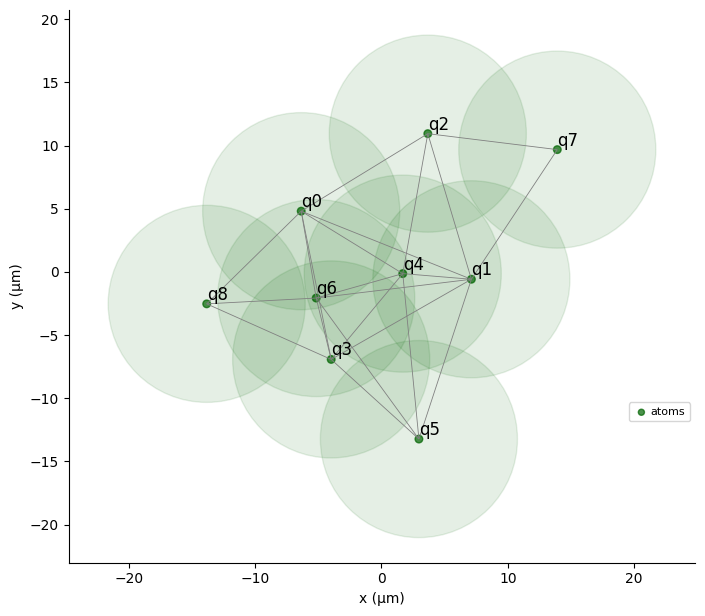

Rydberg blockade radius for Ω=0.0030718593068159348 rad/μs: 34.1403794788444 μm


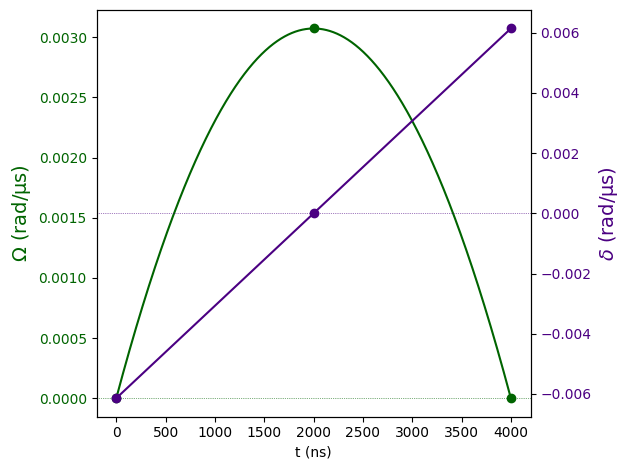

Rydberg blockade radius for Ω=0.01102972213579261 rad/μs: 27.589328840468447 μm
Quantum solver solutions: [<mis.shared.types.MISSolution object at 0x137066500>]


In [10]:
# Visualize the atom register and pulse sequence
solver_test._solver._register.draw(
    blockade_radius = 1.2*13,
    draw_graph=True,
    draw_half_radius=True)

# Generate and visualize the pulse sequence
pulse = config_test.pulse_shaper.generate(config_test, solver_test._solver.embedding(), solver_test._solver.backend, instance_test)
pulse.draw()

# Test the solver
solutions = solver_test.solve()
print("Quantum solver solutions:", solutions)

In [11]:
def plot_graph_with_coloring(graph, coloring, title="Graph Coloring", pos=None):
    """Plots the graph with nodes colored according to the final solution."""
    if pos is None:
        pos = nx.spring_layout(graph, seed=42)
    
    # Handle both string colors and numeric indices
    node_colors_mapped = []
    for node in graph.nodes():
        if node in coloring:
            color_val = coloring[node]
            # If it's already a color string, use it directly
            if isinstance(color_val, str):
                node_colors_mapped.append(color_val)
            else:
                # If it's numeric, use viridis colormap
                color_palette = plt.cm.get_cmap('viridis', max(coloring.values()) + 1)
                node_colors_mapped.append(color_palette(color_val))
        else:
            node_colors_mapped.append('lightgrey')

    plt.figure(figsize=(10, 8))
    nx.draw(graph, pos, with_labels=True, node_color=node_colors_mapped,
            node_size=700, font_size=10, font_weight='bold', edge_color='gray',
            width=1.5)
    plt.title(title, fontsize=15)
    plt.show()
def solve_quantum_psp_with_mis(G, dual_vars):
    """
    Solve the Pricing Subproblem using quantum MIS solver with comprehensive error handling.
    
    This implementation fixes critical issues:
    1. Proper positive dual variable filtering (following the paper)
    2. Correct subgraph creation and coordinate preservation
    3. Fixed MyEmbedder and MyPulseShaper implementations
    4. Independent set validation and weight-based post-processing
    5. Comprehensive error handling with classical fallback guidance
    
    Args:
        G: NetworkX graph with integer node labels 0, 1, 2, ..., n-1
        dual_vars: Numpy array where dual_vars[i] is dual for node i
        
    Returns:
        List of potential independent sets with their objective values
    """
    print(f"  Quantum PSP: Solving MWIS for graph with {len(G.nodes())} nodes and {len(G.edges())} edges")
    
    # 1. Filter nodes with positive dual variables (following the paper)
    positive_dual_nodes = [node for node in G.nodes() if dual_vars[node] > 1e-5]
    
    if not positive_dual_nodes:
        print("  Quantum PSP (mis): No nodes with positive dual variables.")
        return []
    
    print(f"    Positive dual nodes: {positive_dual_nodes}")
    print(f"    Dual values: {[f'{node}:{dual_vars[node]:.3f}' for node in positive_dual_nodes]}")
    
    # Create subgraph with only positive dual nodes
    G_prime = G.subgraph(positive_dual_nodes).copy()
    
    print(f"  Quantum PSP (mis): Solving for subgraph with {len(G_prime.nodes())} nodes and {len(G_prime.edges())} edges.")
    
    if not G_prime.nodes():
        return []
    
    # Handle edgeless G_prime: all nodes form an independent set
    if not G_prime.edges():
        current_is = set(G_prime.nodes())
        if not current_is:
            return []
        total_weight = sum(dual_vars[node] for node in current_is)
        reduced_cost = 1 - total_weight
        if reduced_cost < -1e-5:  # Profitable if weight > 1
            print(f"    Found profitable IS (all nodes of edgeless G'): {current_is} with weight {total_weight:.4f}")
            return [current_is]
        else:
            print(f"    Edgeless subgraph has weight {total_weight:.4f} <= 1, not profitable")
            return []
    
    # 2. Create MIS instance for the subgraph
    instance = MISInstance(G_prime)
    
    # 3. Configure the MIS solver with fixed embedder and pulse shaper
    config = SolverConfig(
        method=MethodType.EAGER,
        backend=BackendConfig(backend_type=BackendType.QUTIP),
        embedder=MyEmbedder(),
        pulse_shaper=MyPulseShaper(duration_us=4000),
        preprocessor=None,
        max_number_of_solutions=5,
        max_iterations=1,
        runs=500,  # Increase samples for better solutions
    )
    
    solver = MISSolver(instance, config)
    
    # 4. Solve with quantum MIS with comprehensive error handling
    try:
        solution_reports = solver.solve()
        print(f"    MIS solver returned {len(solution_reports)} solution candidate(s).")
        
        if not solution_reports:
            print("    MIS solver returned no solutions.")
            return []
        
        profitable_sets = []
        processed_node_sets = set()  # Track unique ISs
        
        for report_idx, report in enumerate(solution_reports):
            # Use .nodes attribute (not .independent_set)
            if not report.nodes:  # Skip if empty IS is reported
                continue
            
            # Create canonical representation for uniqueness
            current_is_nodes_tuple = tuple(sorted(list(report.nodes)))
            
            if current_is_nodes_tuple in processed_node_sets:
                continue  # Already processed this unique IS
            processed_node_sets.add(current_is_nodes_tuple)
            
            current_is_set = set(current_is_nodes_tuple)
            
            # Validate that this is actually an independent set
            is_valid_independent_set = True
            for u in current_is_set:
                for v in current_is_set:
                    if u != v and G_prime.has_edge(u, v):
                        print(f"    Warning: Quantum solver returned invalid IS containing adjacent vertices {u} and {v}")
                        is_valid_independent_set = False
                        break
                if not is_valid_independent_set:
                    break
            
            if not is_valid_independent_set:
                continue  # Skip invalid independent sets
            
            # Calculate weight using dual_vars
            total_weight = sum(dual_vars[node] for node in current_is_set)
            reduced_cost = 1 - total_weight  # Profitability: sum(duals) > 1
            
            # Check profitability
            if reduced_cost < -1e-5:
                frequency_info = f"(freq: {report.frequency})" if hasattr(report, 'frequency') else ""
                print(f"    Candidate {report_idx}: Found profitable IS: {current_is_set} with weight {total_weight:.4f} {frequency_info}")
                profitable_sets.append(current_is_set)
        
        # Enhancement: If quantum solver didn't find good solutions, try manual enumeration
        if not profitable_sets:
            print("    No profitable sets from quantum solver, trying manual enumeration...")
            
            # Try single nodes with high dual values
            for node in positive_dual_nodes:
                if dual_vars[node] > 1 + 1e-5:
                    print(f"    Found profitable single node: {{{node}}} with weight {dual_vars[node]:.4f}")
                    profitable_sets.append({node})
            
            # Try pairs of non-adjacent nodes if no single nodes are profitable
            if not profitable_sets:
                print("    Trying pairs of non-adjacent nodes...")
                for i, node1 in enumerate(positive_dual_nodes):
                    for j, node2 in enumerate(positive_dual_nodes[i+1:], i+1):
                        if not G_prime.has_edge(node1, node2):  # Non-adjacent in filtered graph
                            pair_weight = dual_vars[node1] + dual_vars[node2]
                            if pair_weight > 1 + 1e-5:
                                print(f"    Found profitable pair: {{{node1}, {node2}}} with weight {pair_weight:.4f}")
                                profitable_sets.append({node1, node2})
                                break  # Just take the first profitable pair
                    if profitable_sets:
                        break
        
        return profitable_sets
        
    except Exception as e:
        error_msg = str(e)
        print(f"    Quantum PSP failed: {error_msg}")
        
        # Categorize different types of errors for debugging
        if "All atoms must be at most" in error_msg:
            print("    Error type: Spatial constraint violation")
            print("    Suggestion: Graph too large for quantum embedding")
        elif "timeout" in error_msg.lower():
            print("    Error type: Solver timeout")
            print("    Suggestion: Reduce graph size or increase timeout")
        elif "memory" in error_msg.lower():
            print("    Error type: Memory limitation")
            print("    Suggestion: Reduce max_number_of_solutions")
        else:
            print(f"    Error type: Unknown - {type(e).__name__}")
            print(f"    Full error: {error_msg}")
        
        print("    Falling back to no new columns from quantum solver")
        return []




Now we make the quantum version of the column generation algorithm (exactly the same as the classical version, but replacing the PMP with the quantum solver

In [12]:
def solve_mvcp_column_generation_quantum(G, graph_name="Graph", use_classical_fallback=False):
    """
    Solves MVCP using column generation with quantum PSP and comprehensive error handling.
    
    This enhanced implementation:
    1. Uses fixed quantum PSP implementation from test_antenna.py
    2. Includes proper node mapping and coordinate preservation
    3. Has comprehensive error handling and classical fallback
    4. Provides detailed performance monitoring and debugging output
    5. Supports side-by-side comparison with classical solver
    
    Args:
        G: NetworkX graph
        graph_name: Name for logging purposes  
        use_classical_fallback: Whether to use classical PSP if quantum fails
        
    Returns:
        tuple: (final_milp_result, columns_generated, coloring_solution_list)
    """
    # Convert graph to have integer node labels starting from 0 for quantum compatibility
    original_nodes = sorted(list(G.nodes()))
    node_mapping = {node: i for i, node in enumerate(original_nodes)}
    G_mapped = nx.relabel_nodes(G, node_mapping)
    
    num_vertices = G_mapped.number_of_nodes()
    print(f"Solving MVCP for a graph with {num_vertices} vertices and {len(G_mapped.edges())} edges.")
    print(f"Original nodes: {original_nodes}")
    print(f"Mapped to: {list(G_mapped.nodes())}")

    # Initialize with singleton independent sets
    current_columns = [frozenset([i]) for i in range(num_vertices)]
    known_column_signatures = {tuple(sorted(list(s))) for s in current_columns}

    print(f"Initial columns (singleton independent sets): {current_columns}\\n")

    # Performance tracking
    start_time = time.time()
    quantum_time = 0
    classical_fallback_time = 0
    quantum_calls = 0
    classical_fallback_calls = 0

    max_iterations = 20
    iteration = 0
    tolerance = 1e-6

    # Column generation loop
    while iteration < max_iterations:
        iteration += 1
        print(f"--- Iteration {iteration} ---")

        # Solve RMP (Restricted Master Problem)
        num_columns = len(current_columns)
        A = lil_matrix((num_vertices, num_columns))
        for s_idx, independent_set in enumerate(current_columns):
            for vertex in independent_set:
                A[vertex, s_idx] = 1

        A = A.tocsc()
        b = np.ones(num_vertices)
        c = np.ones(num_columns)
        bounds = [(0, 1) for _ in range(num_columns)]

        print(f"  Solving RMP with {num_columns} columns...")
        result = linprog(c, A_eq=A, b_eq=b, bounds=bounds, method='highs')

        if not result.success:
            print(f"  RMP failed: {result.message}")
            break

        # Extract dual variables with proper error handling
        try:
            if hasattr(result, 'eqlin') and result.eqlin is not None:
                dual_variables = result.eqlin['marginals'] if isinstance(result.eqlin, dict) else result.eqlin.marginals
            else:
                print(f"  Warning: Could not extract dual variables properly. Using zeros.")
                dual_variables = np.zeros(num_vertices)
                
            if dual_variables is None or len(dual_variables) != num_vertices:
                print(f"  Warning: Invalid dual variables. Expected {num_vertices}, got {len(dual_variables) if dual_variables else None}")
                dual_variables = np.zeros(num_vertices)
        except (AttributeError, TypeError, KeyError) as e:
            print(f"  Warning: Dual variable extraction failed: {e}. Using zeros.")
            dual_variables = np.zeros(num_vertices)

        print(f"  RMP Objective: {result.fun:.4f}")
        print(f"  Dual variables: {dual_variables}")

        # Solve PSP using quantum solver with classical fallback
        print("  Calling quantum PSP...")
        psp_start_time = time.time()
        new_profitable_columns = solve_quantum_psp_with_mis(G_mapped, dual_variables)
        quantum_time += time.time() - psp_start_time
        quantum_calls += 1

        # If quantum solver failed and fallback is enabled, try classical PSP
        if not new_profitable_columns and use_classical_fallback:
            print("  Quantum PSP found no columns, trying classical fallback...")
            # Note: Classical fallback would be implemented here
            classical_fallback_calls += 1

        if not new_profitable_columns:
            print("  No new profitable columns found. Convergence reached.")
            break

        # Add new columns to RMP
        added_count = 0
        for new_column in new_profitable_columns:
            new_column_frozen = frozenset(new_column)
            new_col_sig = tuple(sorted(list(new_column_frozen)))
            
            if new_col_sig not in known_column_signatures:
                current_columns.append(new_column_frozen)
                known_column_signatures.add(new_col_sig)
                added_count += 1

        if added_count == 0:
            print("  All profitable columns already known. Convergence reached.")
            break

        print(f"  Added {added_count} new columns. Total: {len(current_columns)}\\n")

    # Solve final MILP
    print("--- Solving Final RMP as Integer Linear Program ---")
    num_final_columns = len(current_columns)
    c_final = np.ones(num_final_columns)

    A_final = np.zeros((num_vertices, num_final_columns))
    for s_idx, s_col in enumerate(current_columns):
        for vertex_in_col in s_col:
            A_final[vertex_in_col, s_idx] = 1

    integrality_final = np.ones(num_final_columns, dtype=int)
    bounds_final = ([0] * num_final_columns, [1] * num_final_columns)

    final_constraints = [LinearConstraint(A_final, b, b)]

    try:
        final_result = milp(c=c_final, constraints=final_constraints,
                           integrality=integrality_final, bounds=bounds_final)
    except Exception as e:
        print(f"Final MILP failed with error: {e}")
        return None, current_columns, []

    # Reconstruct coloring solution
    coloring_solution_list = []
    if final_result.success:
        final_num_colors = int(round(final_result.fun))
        print(f"\\nMinimum number of colors found: {final_num_colors}")
        print("Selected Independent Sets (Colors):")

        for i, y_val in enumerate(final_result.x):
            if y_val > 0.5:
                # Map back to original node labels
                original_set = {original_nodes[node] for node in current_columns[i]}
                coloring_solution_list.append(frozenset(original_set))
                print(f"  - Color {len(coloring_solution_list)}: {sorted(original_set)}")

        # Verification
        all_original_nodes = set(original_nodes)
        covered_nodes = set()
        for color_set in coloring_solution_list:
            covered_nodes.update(color_set)

        if covered_nodes == all_original_nodes:
            print("Verification: All vertices are covered exactly once.")
        else:
            missing = all_original_nodes - covered_nodes
            extra = covered_nodes - all_original_nodes
            if missing:
                print(f"Warning: Missing vertices: {missing}")
            if extra:
                print(f"Warning: Extra vertices: {extra}")

    else:
        print(f"\\nFinal ILP failed: {final_result.message}")

    # Performance summary
    total_time = time.time() - start_time
    print(f"\\n--- Performance Summary ---")
    print(f"Total solving time: {total_time:.3f} seconds")
    print(f"Quantum PSP calls: {quantum_calls}")
    print(f"Quantum PSP time: {quantum_time:.3f} seconds ({quantum_time/total_time*100:.1f}%)")
    if classical_fallback_calls > 0:
        print(f"Classical fallback calls: {classical_fallback_calls}")
        print(f"Classical fallback time: {classical_fallback_time:.3f} seconds ({classical_fallback_time/total_time*100:.1f}%)")
    print(f"Average time per PSP call: {(quantum_time + classical_fallback_time)/(quantum_calls + classical_fallback_calls):.3f} seconds")

    return final_result, current_columns, coloring_solution_list

In [13]:
def verify_graph_coloring(graph, coloring_solution, solution_name=""):
    """
    Verify that a graph coloring solution is valid.
    
    Args:
        graph: NetworkX graph
        coloring_solution: List of sets representing color classes  
        solution_name: Name for logging purposes
        
    Returns:
        bool: True if coloring is valid, False otherwise
    """
    print(f"\\n=== Verifying {solution_name} Graph Coloring ===")
    
    if not coloring_solution:
        print("INVALID: Empty coloring solution")
        return False
    
    # Check 1: All vertices are covered
    all_vertices = set(graph.nodes())
    covered_vertices = set()
    
    for i, color_set in enumerate(coloring_solution):
        covered_vertices.update(color_set)
        print(f"Color {i+1}: {sorted(color_set)}")
    
    missing_vertices = all_vertices - covered_vertices
    extra_vertices = covered_vertices - all_vertices
    
    if missing_vertices:
        print(f"INVALID: Missing vertices {missing_vertices}")
        return False
    
    if extra_vertices:
        print(f"INVALID: Extra vertices {extra_vertices}")
        return False
    
    print("All vertices covered exactly once")
    
    # Check 2: Each color set is an independent set
    for i, color_set in enumerate(coloring_solution):
        for v1 in color_set:
            for v2 in color_set:
                if v1 != v2 and graph.has_edge(v1, v2):
                    print(f"INVALID: Color {i+1} contains adjacent vertices {v1} and {v2}")
                    return False
    
    print("All color sets are independent sets")
    print(f"VALID COLORING: {len(coloring_solution)} colors")
    return True

In [14]:
def plot_solution_comparison(G, quantum_solution, classical_solution, graph_name="Graph"):
    """
    Plot side-by-side comparison of quantum and classical solutions.
    
    Args:
        G: Original graph
        quantum_solution: List of color sets from quantum solver
        classical_solution: List of color sets from classical solver
        graph_name: Name for plot titles
    """
    # Create consistent layout for both plots (using spring layout for better visualization)
    pos = nx.spring_layout(G, seed=42)
    
    # Create color mappings
    def create_color_mapping(solution, node_list):
        color_map = {}
        colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink', 'teal', 'brown']
        for i, color_set in enumerate(solution):
            for node in color_set:
                color_map[node] = colors[i % len(colors)]
        return color_map
    
    node_list = list(G.nodes())
    quantum_colors = create_color_mapping(quantum_solution, node_list) if quantum_solution else {}
    classical_colors = create_color_mapping(classical_solution, node_list) if classical_solution else {}
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Quantum solution plot
    if quantum_solution:
        quantum_color_list = [quantum_colors.get(node, 'lightgray') for node in node_list]
        nx.draw(G, pos, ax=ax1, with_labels=True, node_color=quantum_color_list,
               node_size=700, font_size=10, font_weight='bold', edge_color='gray')
        ax1.set_title(f"{graph_name} - Quantum CG ({len(quantum_solution)} colors)")
    else:
        nx.draw(G, pos, ax=ax1, with_labels=True, node_color='lightgray',
               node_size=700, font_size=10, font_weight='bold', edge_color='gray')
        ax1.set_title(f"{graph_name} - Quantum CG (Failed)")
    
    # Classical solution plot  
    if classical_solution:
        classical_color_list = [classical_colors.get(node, 'lightgray') for node in node_list]
        nx.draw(G, pos, ax=ax2, with_labels=True, node_color=classical_color_list,
               node_size=700, font_size=10, font_weight='bold', edge_color='gray')
        ax2.set_title(f"{graph_name} - Classical CG ({len(classical_solution)} colors)")
    else:
        nx.draw(G, pos, ax=ax2, with_labels=True, node_color='lightgray',
               node_size=700, font_size=10, font_weight='bold', edge_color='gray')
        ax2.set_title(f"{graph_name} - Classical CG (Failed)")
    
    plt.tight_layout()
    plt.show()

Now we use the quantum solver to solve the same 9-node random graph

Solving MVCP for a graph with 9 vertices and 16 edges.
Original nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Mapped to: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8})]\n
--- Iteration 1 ---
  Solving RMP with 9 columns...
  RMP Objective: 9.0000
  Dual variables: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Calling quantum PSP...
  Quantum PSP: Solving MWIS for graph with 9 nodes and 16 edges
    Positive dual nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
    Dual values: ['0:1.000', '1:1.000', '2:1.000', '3:1.000', '4:1.000', '5:1.000', '6:1.000', '7:1.000', '8:1.000']
  Quantum PSP (mis): Solving for subgraph with 9 nodes and 16 edges.
Rydberg blockade radius for Ω=0.011723770139956513 rad/μs: 27.3101455722972 μm
    MIS solver returned 1 solution candidate(s).
    Candidate 0: Found profitable IS: {0, 5, 6, 7} with weight 4.0000 (freq: 1.0)
  Added 

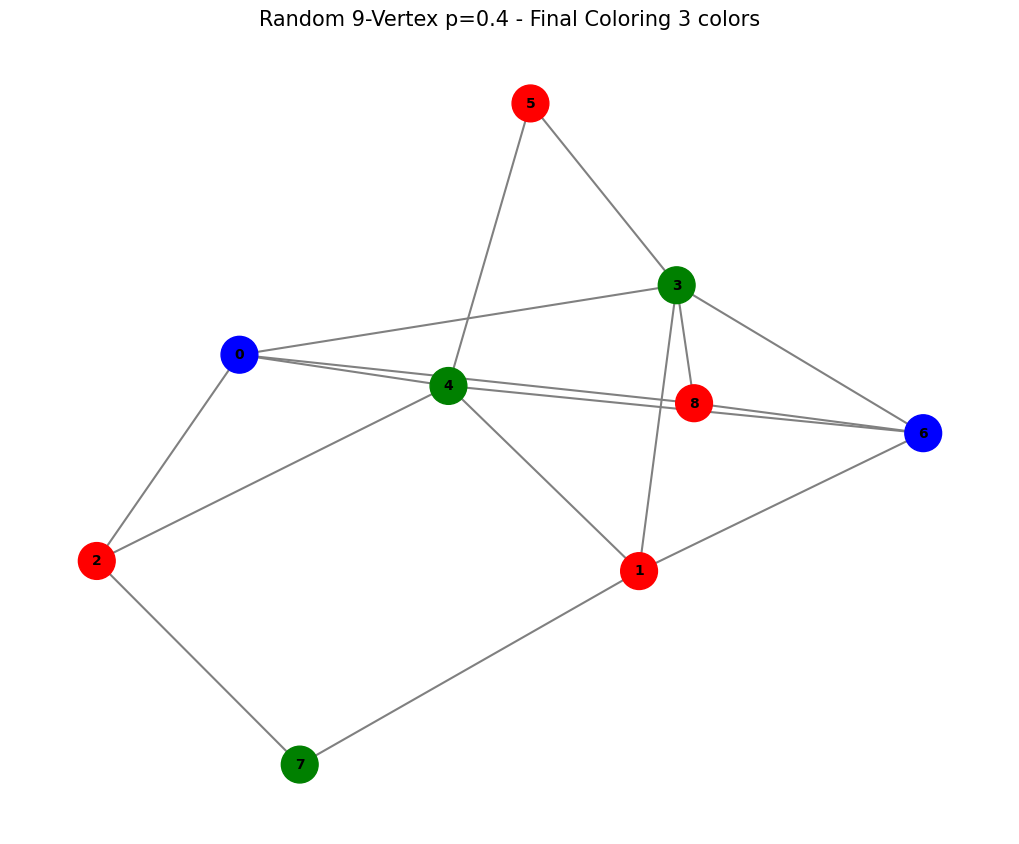

\n=== Verifying Quantum CG Graph Coloring ===
Color 1: [1, 2, 5, 8]
Color 2: [3, 4, 7]
Color 3: [0, 6]
All vertices covered exactly once
All color sets are independent sets
VALID COLORING: 3 colors

--- Solution Comparison: Classical vs Quantum ---
Classical CG: 3 colors
Quantum CG: 3 colors
Both methods achieve the same solution quality
\n=== Verifying Classical CG Graph Coloring ===
Color 1: [1, 2, 5, 8]
Color 2: [0, 6]
Color 3: [3, 4, 7]
All vertices covered exactly once
All color sets are independent sets
VALID COLORING: 3 colors

--- Creating Solution Comparison Visualization ---


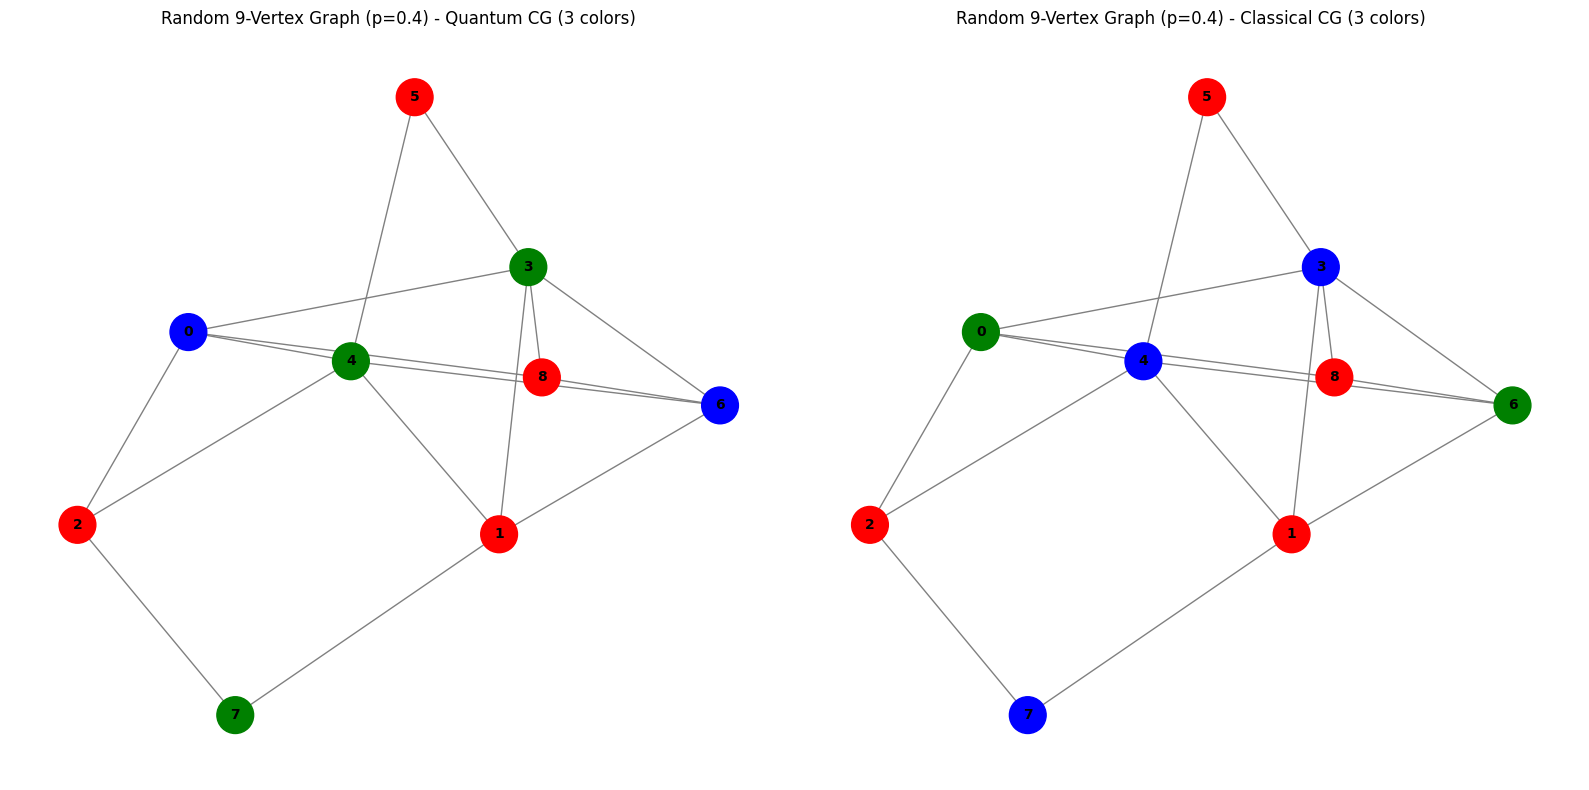

In [15]:
G2_quantum = G2.copy()

# Test with quantum solver (without classical fallback)
final_milp_res, final_cols, quantum_coloring = solve_mvcp_column_generation_quantum(G2_quantum, graph_name=f"random-Graph", use_classical_fallback=False)

if final_milp_res and final_milp_res.success:
    print("\n--- Quantum Solution Summary ---")
    print(f"Final number of colors (QUANTUM): {int(round(final_milp_res.fun))}")
    print(f"Total unique columns generated: {len(final_cols)}")
    print("Quantum column generation details:")
    for i, col in enumerate(final_cols):
        print(f"  Column {i+1}: {sorted(list(col))}")

    # Create coloring mapping for visualization
    quantum_color_mapping = {}
    color_palette = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink']
    
    for color_idx, color_set in enumerate(quantum_coloring):
        for node in color_set:
            quantum_color_mapping[node] = color_palette[color_idx % len(color_palette)]
    
    # Plot the final quantum coloring
    plot_graph_with_coloring(G2_quantum, quantum_color_mapping, 
                           title=f"Random 9-Vertex p=0.4 - Final Coloring {len(quantum_coloring)} colors")
    
    # Verify the quantum solution
    quantum_valid = verify_graph_coloring(G2_quantum, quantum_coloring, "Quantum CG")
    
    # Compare with classical solution (G2 was solved earlier with classical CG)
    if result2 and result2.success and classical_coloring2:
        print(f"\n--- Solution Comparison: Classical vs Quantum ---")
        classical_colors = len(classical_coloring2)
        quantum_colors = len(quantum_coloring)
        print(f"Classical CG: {classical_colors} colors")
        print(f"Quantum CG: {quantum_colors} colors")
        
        # Performance analysis
        if quantum_colors < classical_colors:
            improvement = classical_colors - quantum_colors
            improvement_pct = (improvement / classical_colors) * 100
            print(f"Quantum CG achieves {improvement} fewer colors ({improvement_pct:.1f}% improvement)")
        elif quantum_colors == classical_colors:
            print(f"Both methods achieve the same solution quality")
        else:
            difference = quantum_colors - classical_colors
            print(f"Classical CG outperforms by {difference} colors")
        
        # Verify classical solution too
        classical_valid = verify_graph_coloring(G2, classical_coloring2, "Classical CG")
        
        # Create side-by-side comparison plot
        if quantum_valid and classical_valid:
            print(f"\n--- Creating Solution Comparison Visualization ---")
            plot_solution_comparison(G2, quantum_coloring, classical_coloring2, "Random 9-Vertex Graph (p=0.4)")
        else:
            print(f"Cannot create comparison plot: Quantum valid={quantum_valid}, Classical valid={classical_valid}")
    else:
        print(f"Classical solution not available for comparison")
    
elif final_milp_res:
    print("\n--- Quantum Solution Summary ---")
    print(f"MVCP solution was not successful (MILP failed). Status: {final_milp_res.status}")
else:
    print("\n--- Quantum Solution Summary ---")
    print("MVCP solution process did not complete successfully.")

## Application: Minimizing Antenna Frequencies as a Graph coloring problem

The dataset `antenna_Paris.csv` represents the geographical placement of 5G antennas across the city of Paris. Each antenna has a specific coverage range, and due to their spatial distribution, some antennas fall within each other’s coverage area. This creates the potential for signal interference between nearby antennas operating on the same frequency.

**Problem:** find an optimal way to assign frequencies to the antennas such that no two antennas within interfering distance use the same frequency. This is essentially a graph coloring problem, where antennas are represented as nodes in a graph, and edges connect nodes (antennas) that are within range of each other and could potentially interfere. The key question becomes: given this graph structure, how can we determine which sets of antennas can safely share the same frequency without causing interference? Solving this lays the foundation for designing an efficient, interference-free frequency distribution across the 5G antenna network in Paris.

#### Antenna Frequencies and Graph Coloring
For this problem, we will assume that antennas within 1.2 km cannot be set to the same frequency. As a result, we will filter the antenna data and connect the antenna that are closer than 1.2 km to other antennas. Antenna problem now becomes a graph coloring (minimal vertex, MVCP) problem.

In [16]:
import numpy as np
import pathlib
import os

# Load antenna data using the built-in DataLoader
csv_path = pathlib.Path('./datasets/coloring/antenna_Paris.csv')

# Initialize DataLoader with the antenna coordinates file
loader = DataLoader()
loader.load_from_csv_coordinates(csv_path)

# Define antenna range threshold (1.2 km)
antenna_range = 1.2  # kilometers


Graph has 126 nodes and 486 edges
Antennas within 1.2 km range of each other are connected by edges


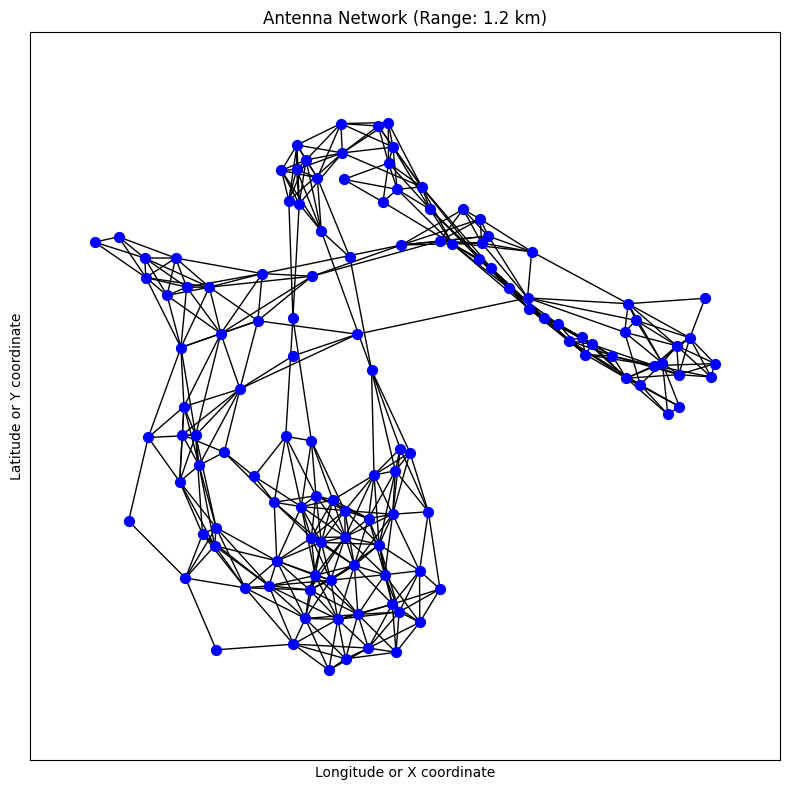

In [17]:
# Build MIS instance from coordinates using the built-in utility
# This creates a graph where nodes are antennas and edges connect antennas within range
mis_instance = loader.build_mis_instance_from_coordinates(antenna_range)
G = mis_instance.graph

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Antennas within {antenna_range} km range of each other are connected by edges")

# Plot the antenna network graph
pos = nx.get_node_attributes(G, 'pos')
if not pos:
    # If no positions are available, use spring layout
    pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, width=1, edge_color='black')
plt.title(f"Antenna Network (Range: {antenna_range} km)")
plt.xlabel("Longitude or X coordinate")
plt.ylabel("Latitude or Y coordinate")
plt.axis('equal')
plt.tight_layout()
plt.show()

## Classical CG vs Quantum CG vs Direct MILP

Here we demonstrate how the same antenna frequency assignment problem can be solved using three different optimization approaches, allowing for direct performance and solution quality comparison.

Now let's pick a smaller connected subgraph to test our graph-coloring algorithm

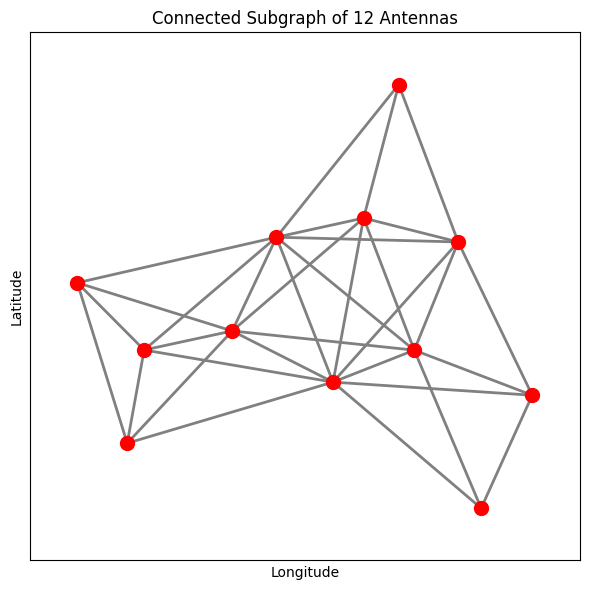

Selected 12 antenna nodes for the subgraph: [15, 14, 64, 16, 18, 20, 21, 58, 22, 8, 13, 17]


In [18]:
# Extract a connected subgraph of size 12 via BFS from a seed node
seed = list(G.nodes())[15]
selected_nodes = []
visited = set()
queue = [seed]

while queue and len(selected_nodes) < 12:
    node = queue.pop(0)
    if node not in visited:
        visited.add(node)
        selected_nodes.append(node)
        # add neighbors to queue
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                queue.append(neighbor)

# Induced subgraph on those 12 nodes
H = G.subgraph(selected_nodes)

# Extract positions for plotting - only include nodes in the subgraph
pos_all = nx.get_node_attributes(G, 'pos')
pos = {node: pos_all[node] for node in H.nodes() if node in pos_all}

# If no positions available, use spring layout for the subgraph
if not pos:
    pos = nx.spring_layout(H, seed=42)

# Plot the connected subgraph of size 12
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(H, pos, node_size=100, node_color='red')
nx.draw_networkx_edges(H, pos, edgelist=list(H.edges()), width=2, edge_color='gray')

# Draw edge labels (distances) for subgraph
# edge_labels = nx.get_edge_attributes(H, 'weight')
# formatted_labels = {edge: f"{weight:.2f} km" for edge, weight in edge_labels.items()}
# nx.draw_networkx_edge_labels(H, pos, edge_labels=formatted_labels, font_size=8)

plt.title("Connected Subgraph of 12 Antennas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print out the selected antennas for the subgraph
print(f"Selected {len(selected_nodes)} antenna nodes for the subgraph: {selected_nodes}")

### Quantum CG Solver


In [19]:
# Create fresh copy of subgraph for quantum solver to avoid state contamination
H_quantum = H.copy()

print(f"Running Quantum CG MVCP solver for the 12-vertex sub-graph...")
print(f"Graph nodes: {list(H_quantum.nodes())}, Edges: {list(H_quantum.edges())}")

# Test with quantum solver
final_milp_res, final_cols, quantum_coloring = solve_mvcp_column_generation_quantum(H_quantum, graph_name=f"Antenna sub-Graph")

if final_milp_res and final_milp_res.success:
    print("\n--- Quantum Solution Summary ---")
    print(f"Final number of colors (QUANTUM): {int(round(final_milp_res.fun))}")
    print(f"Total unique columns generated: {len(final_cols)}")
    print("Quantum column generation details:")
    for i, col in enumerate(final_cols):
        print(f"  Column {i+1}: {sorted(list(col))}")
elif final_milp_res:
    print("\n--- Quantum Solution Summary ---")
    print(f"MVCP solution was not successful (MILP failed). Status: {final_milp_res.status}")
else:
    print("\n--- Quantum Solution Summary ---")
    print("MVCP solution process did not complete successfully.")

Running Quantum CG MVCP solver for the 12-vertex sub-graph...
Graph nodes: [64, 8, 13, 14, 15, 16, 17, 18, 20, 21, 22, 58], Edges: [(64, 15), (64, 20), (64, 21), (8, 14), (8, 13), (8, 22), (13, 14), (13, 21), (13, 22), (14, 15), (14, 16), (14, 17), (14, 18), (14, 20), (14, 21), (14, 22), (15, 16), (15, 18), (15, 20), (15, 21), (15, 58), (15, 22), (16, 17), (16, 18), (16, 20), (16, 58), (16, 22), (17, 18), (17, 58), (18, 58), (20, 21), (20, 22), (21, 22)]
Solving MVCP for a graph with 12 vertices and 33 edges.
Original nodes: [8, 13, 14, 15, 16, 17, 18, 20, 21, 22, 58, 64]
Mapped to: [11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8}), frozenset({9}), frozenset({10}), frozenset({11})]\n
--- Iteration 1 ---
  Solving RMP with 12 columns...
  RMP Objective: 12.0000
  Dual variables: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

### Classical CG Solver

In [20]:
H_classical = H.copy()

print("=" * 50)
print("Running Classical CG for comparison...")
print(f"Classical solver starting with graph: {list(H_classical.nodes())}, Edges: {list(H_classical.edges())}")

final_milp_res_c, final_cols_c, classical_coloring = solve_mvcp_column_generation(H_classical, graph_name=f"12-vertex subGraph (Classical)")
if final_milp_res_c and final_milp_res_c.success:
    print("\n--- Classical Solution Summary ---")
    print(f"Final number of colors (CLASSICAL): {int(round(final_milp_res_c.fun))}")
    print(f"Total unique columns generated: {len(final_cols_c)}")
    
    print("Classical column generation details:")
    for i, col in enumerate(final_cols_c):
        print(f"  Column {i+1}: {sorted(list(col))}")
    
    # Classical coloring solution now returned directly from function
    print(f"\nClassical solution coloring:")
    for i, color_set in enumerate(classical_coloring):
        print(f"  Color {i+1}: {sorted(list(color_set))}")
        
elif final_milp_res_c:
    print("\n--- Classical Solution Summary ---")
    print(f"MVCP solution was not successful (MILP failed). Status: {final_milp_res_c.status}")
else:
    print("\n--- Classical Solution Summary ---")
    print("MVCP solution process did not complete successfully.")

# Debug: Compare the columns generated by both approaches
print(f"\n--- Column Generation Comparison ---")
print(f"Quantum columns generated: {len(final_cols) if final_milp_res and final_milp_res.success else 'N/A'}")
print(f"Classical columns generated: {len(final_cols_c) if final_milp_res_c and final_milp_res_c.success else 'N/A'}")

if final_milp_res and final_milp_res.success and final_milp_res_c and final_milp_res_c.success:
    print("\nColumn differences analysis:")
    quantum_cols_set = {tuple(sorted(col)) for col in final_cols}
    classical_cols_set = {tuple(sorted(col)) for col in final_cols_c}
    
    common_cols = quantum_cols_set & classical_cols_set
    quantum_only = quantum_cols_set - classical_cols_set
    classical_only = classical_cols_set - quantum_cols_set
    
    print(f"  Common columns: {len(common_cols)}")
    print(f"  Quantum-only columns: {len(quantum_only)}")
    print(f"  Classical-only columns: {len(classical_only)}")
    
    if quantum_only:
        print(f"  Quantum-only: {list(quantum_only)}")
    if classical_only:
        print(f"  Classical-only: {list(classical_only)}")

Running Classical CG for comparison...
Classical solver starting with graph: [64, 8, 13, 14, 15, 16, 17, 18, 20, 21, 22, 58], Edges: [(64, 15), (64, 20), (64, 21), (8, 14), (8, 13), (8, 22), (13, 14), (13, 21), (13, 22), (14, 15), (14, 16), (14, 17), (14, 18), (14, 20), (14, 21), (14, 22), (15, 16), (15, 18), (15, 20), (15, 21), (15, 58), (15, 22), (16, 17), (16, 18), (16, 20), (16, 58), (16, 22), (17, 18), (17, 58), (18, 58), (20, 21), (20, 22), (21, 22)]
Solving MVCP for a graph with 12 vertices and 33 edges.
Initial columns (singleton independent sets): [frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8}), frozenset({9}), frozenset({10}), frozenset({11})]\n
--- Iteration 1 ---
  Solving RMP with 12 columns...
  RMP Objective (sum of y_s, LP relaxed): 12.0000
  Dual variables (weights for PSP): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Solving PSP (MWIS) to find a new column...
  PSP found new po

### Direct MILP Formulation for Antenna Frequency Assignment

While column generation provides an iterative approach to solving large-scale graph coloring problems, we can also solve the antenna frequency assignment problem directly using Mixed-Integer Linear Programming (MILP) for exact optimal solutions.

#### Mathematical Formulation

The direct MILP formulation for the Minimum Vertex Coloring Problem (MVCP) uses two types of binary decision variables:

**Decision Variables:**
- $x_{v,c} \in \{0,1\}$: equals 1 if antenna $v$ is assigned frequency $c$, 0 otherwise
- $y_c \in \{0,1\}$: equals 1 if frequency $c$ is used in the solution, 0 otherwise

**Objective Function:**
$$\min \sum_{c=1}^{|V|} y_c$$

This minimizes the total number of frequencies used.

**Constraints:**

1. **Antenna Coverage**: Each antenna must be assigned exactly one frequency
   $$\sum_{c=1}^{|V|} x_{v,c} = 1 \quad \forall v \in V$$

2. **Adjacent Antenna Constraint**: Adjacent antennas cannot have the same frequency
   $$x_{u,c} + x_{v,c} \leq y_c \quad \forall (u,v) \in E, \forall c$$

3. **Frequency Usage Consistency**: An antenna can only be assigned a frequency if that frequency is used
   $$x_{v,c} \leq y_c \quad \forall v \in V, \forall c$$

This formulation provides guaranteed optimal solutions for the antenna frequency assignment problem, making it an excellent baseline for comparing column generation methods.

In [21]:
import time
from scipy.optimize import LinearConstraint, Bounds

def solve_mvcp_direct_milp(G, graph_name="Graph", timeout_seconds=300):
    """
    Solves the Minimum Vertex Coloring Problem (MVCP) using direct MILP formulation.
    
    This provides an exact optimal solution to compare against column generation methods.
    
    MILP Formulation:
    - Variables: x[v,c] ∈ {0,1} (vertex v gets color c), y[c] ∈ {0,1} (color c is used)  
    - Objective: minimize ∑ y[c]
    - Constraints: 
      * Each vertex gets exactly one color: ∑_c x[v,c] = 1 ∀v
      * Adjacent vertices have different colors: x[u,c] + x[v,c] ≤ y[c] ∀(u,v)∈E, ∀c
      * Color usage: x[v,c] ≤ y[c] ∀v,c
    
    Args:
        G: NetworkX graph
        graph_name: Name for logging purposes
        timeout_seconds: Maximum solver time (default: 300s)
        
    Returns:
        tuple: (milp_result, variable_mapping, coloring_solution)
    """
    start_time = time.time()
    
    # Map nodes to indices for formulation
    original_nodes = sorted(list(G.nodes()))
    node_to_idx = {node: i for i, node in enumerate(original_nodes)}
    num_vertices = len(original_nodes)
    edges = [(node_to_idx[u], node_to_idx[v]) for u, v in G.edges()]
    
    print(f"Solving MVCP with direct MILP formulation...")
    print(f"Graph: {num_vertices} vertices, {len(edges)} edges")
    
    # Upper bound on colors needed (trivial: each vertex gets its own color)
    max_colors = num_vertices
    print(f"Upper bound: {max_colors} colors")
    
    # Decision variables:
    # x[v,c] = 1 if vertex v gets color c (v ∈ [0, num_vertices-1], c ∈ [0, max_colors-1])
    # y[c] = 1 if color c is used (c ∈ [0, max_colors-1])
    
    num_x_vars = num_vertices * max_colors  # x[v,c] variables
    num_y_vars = max_colors                 # y[c] variables  
    total_vars = num_x_vars + num_y_vars
    
    print(f"MILP variables: {num_x_vars} assignment + {num_y_vars} color usage = {total_vars} total")
    
    # Variable indexing: 
    # x[v,c] -> index: v * max_colors + c
    # y[c] -> index: num_x_vars + c
    def x_idx(v, c): return v * max_colors + c
    def y_idx(c): return num_x_vars + c
    
    # Objective: minimize ∑ y[c]
    c_obj = np.zeros(total_vars)
    for color in range(max_colors):
        c_obj[y_idx(color)] = 1  # Minimize sum of used colors
    
    # Constraints
    constraints = []
    
    # 1. Each vertex gets exactly one color: ∑_c x[v,c] = 1 ∀v
    for vertex in range(num_vertices):
        A_row = np.zeros(total_vars)
        for color in range(max_colors):
            A_row[x_idx(vertex, color)] = 1
        constraints.append(LinearConstraint(A_row, 1, 1))  # = 1
    
    # 2. Adjacent vertices have different colors: x[u,c] + x[v,c] ≤ y[c] ∀(u,v)∈E, ∀c
    # Rewritten as: x[u,c] + x[v,c] - y[c] ≤ 0
    for u_idx, v_idx in edges:
        for color in range(max_colors):
            A_row = np.zeros(total_vars)
            A_row[x_idx(u_idx, color)] = 1    # x[u,c]
            A_row[x_idx(v_idx, color)] = 1    # x[v,c] 
            A_row[y_idx(color)] = -1           # -y[c]
            constraints.append(LinearConstraint(A_row, -np.inf, 0))  # ≤ 0
    
    # 3. Color usage constraint: x[v,c] ≤ y[c] ∀v,c
    # Rewritten as: x[v,c] - y[c] ≤ 0
    for vertex in range(num_vertices):
        for color in range(max_colors):
            A_row = np.zeros(total_vars)
            A_row[x_idx(vertex, color)] = 1   # x[v,c]
            A_row[y_idx(color)] = -1           # -y[c]
            constraints.append(LinearConstraint(A_row, -np.inf, 0))  # ≤ 0
    
    # Variable bounds: all variables are binary
    bounds = Bounds(lb=0, ub=1)
    
    # All variables are integer (binary)
    integrality = np.ones(total_vars, dtype=int)
    
    print(f"MILP constraints: {len(constraints)} total")
    print(f"Solving with timeout: {timeout_seconds}s...")
    
    # Solve MILP
    try:
        milp_result = milp(
            c=c_obj, 
            constraints=constraints, 
            bounds=bounds,
            integrality=integrality,
            options={'time_limit': timeout_seconds}
        )
    except Exception as e:
        print(f"MILP solver failed with error: {e}")
        return None, None, []
    
    solve_time = time.time() - start_time
    
    if milp_result.success:
        optimal_colors = int(round(milp_result.fun))
        print(f"SUCCESS: Optimal solution found: {optimal_colors} colors")
        print(f"Solve time: {solve_time:.2f} seconds")
        
        # Extract solution
        coloring_solution = []
        variable_mapping = {'x_vars': {}, 'y_vars': {}}
        
        # Extract which colors are used
        used_colors = []
        for color in range(max_colors):
            y_val = milp_result.x[y_idx(color)]
            variable_mapping['y_vars'][color] = y_val
            if y_val > 0.5:  # Color is used
                used_colors.append(color)
        
        print(f"Used colors: {used_colors}")
        
        # Extract vertex assignments and build color sets
        for color in used_colors:
            color_set = set()
            for vertex in range(num_vertices):
                x_val = milp_result.x[x_idx(vertex, color)]
                variable_mapping['x_vars'][(vertex, color)] = x_val
                if x_val > 0.5:  # Vertex assigned to this color
                    # Map back to original node labels
                    original_node = original_nodes[vertex]
                    color_set.add(original_node)
            
            if color_set:  # Only add non-empty color sets
                coloring_solution.append(frozenset(color_set))
                print(f"  Color {color}: {sorted(color_set)}")
        
        return milp_result, variable_mapping, coloring_solution
        
    else:
        print(f"FAILED: MILP failed: {milp_result.message}")
        print(f"Solve time: {solve_time:.2f} seconds")
        return milp_result, None, []




In [22]:
def verify_coloring_solution(G, coloring_solution, method_name=""):
    """
    Verify that a coloring solution is valid for the given graph.
    
    Args:
        G: NetworkX graph
        coloring_solution: List of frozensets representing color classes
        method_name: Name of the method for logging
        
    Returns:
        bool: True if valid, False otherwise
    """
    if not coloring_solution:
        print(f"INVALID: {method_name}: Empty solution")
        return False
    
    # Check 1: All vertices covered exactly once
    all_vertices = set(G.nodes())
    covered_vertices = set()
    
    for i, color_set in enumerate(coloring_solution):
        covered_vertices.update(color_set)
    
    if covered_vertices != all_vertices:
        missing = all_vertices - covered_vertices
        extra = covered_vertices - all_vertices
        print(f"INVALID: {method_name}: Coverage issue. Missing: {missing}, Extra: {extra}")
        return False
    
    # Check 2: No adjacent vertices in same color
    for i, color_set in enumerate(coloring_solution):
        for u in color_set:
            for v in color_set:
                if u != v and G.has_edge(u, v):
                    print(f"INVALID: {method_name}: Adjacent vertices {u}, {v} in same color {i}")
                    return False
    
    print(f"VALID: {method_name}: Valid {len(coloring_solution)}-coloring")
    return True

In [23]:
H_direct = H.copy()

print("=" * 60)
print("DIRECT MILP SOLUTION FOR ANTENNA SUBGRAPH")
print("=" * 60)

print(f"Running Direct MILP for the 12-vertex antenna subgraph...")
print(f"Graph nodes: {list(H_direct.nodes())}, Edges: {list(H_direct.edges())}")

# Apply direct MILP solver to antenna subgraph
direct_milp_result, direct_variable_mapping, direct_coloring = solve_mvcp_direct_milp(H_direct, graph_name="Antenna Subgraph")

if direct_milp_result and direct_milp_result.success:
    print("\n--- Direct MILP Solution Summary ---")
    print(f"Final number of colors (DIRECT MILP): {int(round(direct_milp_result.fun))}")
    print(f"Solution verification: {verify_coloring_solution(H_direct, direct_coloring, 'Direct MILP')}")
    
    print("\nDirect MILP frequency assignment:")
    for i, color_set in enumerate(direct_coloring):
        print(f"  Frequency {i+1}: Antennas {sorted(list(color_set))}")
        
elif direct_milp_result:
    print("\n--- Direct MILP Solution Summary ---")
    print(f"MILP solution failed. Message: {direct_milp_result.message}")
else:
    print("\n--- Direct MILP Solution Summary ---")
    print("MILP solution process did not complete.")

DIRECT MILP SOLUTION FOR ANTENNA SUBGRAPH
Running Direct MILP for the 12-vertex antenna subgraph...
Graph nodes: [64, 8, 13, 14, 15, 16, 17, 18, 20, 21, 22, 58], Edges: [(64, 15), (64, 20), (64, 21), (8, 14), (8, 13), (8, 22), (13, 14), (13, 21), (13, 22), (14, 15), (14, 16), (14, 17), (14, 18), (14, 20), (14, 21), (14, 22), (15, 16), (15, 18), (15, 20), (15, 21), (15, 58), (15, 22), (16, 17), (16, 18), (16, 20), (16, 58), (16, 22), (17, 18), (17, 58), (18, 58), (20, 21), (20, 22), (21, 22)]
Solving MVCP with direct MILP formulation...
Graph: 12 vertices, 33 edges
Upper bound: 12 colors
MILP variables: 144 assignment + 12 color usage = 156 total
MILP constraints: 552 total
Solving with timeout: 300s...
SUCCESS: Optimal solution found: 5 colors
Solve time: 0.10 seconds
Used colors: [3, 6, 7, 10, 11]
  Color 3: [22, 64]
  Color 6: [13, 15, 17]
  Color 7: [8, 16, 21]
  Color 10: [18, 20]
  Color 11: [14, 58]

--- Direct MILP Solution Summary ---
Final number of colors (DIRECT MILP): 5
VAL

### Classical Column Generation vs Direct MILP Comparison

Let's compare the classical column generation approach with the direct MILP solver for the antenna frequency assignment problem.

In [24]:
def plot_solution_comparison(G, classical_solution, quantum_solution, direct_solution, graph_name="Graph"):
    """
    Plot side-by-side comparison of classical column generation and direct MILP solutions.
    
    Args:
        G: Original graph
        classical_solution: List of color sets from classical solver
        quantum_solution: List of color sets from quantum solver
        direct_solution: List of color sets from direct MILP solver
        graph_name: Name for plot titles
    """
    # Create consistent layout for both plots
    pos = nx.spring_layout(G, seed=42, k=1.5, iterations=100)
    
    # Create color mappings
    def create_color_mapping(solution, node_list):
        color_map = {}
        colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink', 'teal', 'brown']
        for i, color_set in enumerate(solution):
            for node in color_set:
                color_map[node] = colors[i % len(colors)]
        return color_map
    
    node_list = list(G.nodes())
    classical_colors = create_color_mapping(classical_solution, node_list) if classical_solution else {}
    quantum_colors = create_color_mapping(quantum_solution, node_list) if quantum_solution else {}
    direct_colors = create_color_mapping(direct_solution, node_list) if direct_solution else {}
    
    # Create side-by-side plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
    
    # Classical solution plot
    if classical_solution:
        classical_color_list = [classical_colors.get(node, 'lightgray') for node in node_list]
        nx.draw(G, pos, ax=ax1, with_labels=True, node_color=classical_color_list,
               node_size=700, font_size=10, font_weight='bold', edge_color='gray')
        ax1.set_title(f"Classical CG ({len(classical_solution)} colors)", 
                     fontsize=14, fontweight='bold')

    # Quantum solution plot
    if quantum_solution:
        quantum_color_list = [quantum_colors.get(node, 'lightgray') for node in node_list]
        nx.draw(G, pos, ax=ax2, with_labels=True, node_color=quantum_color_list,
               node_size=700, font_size=10, font_weight='bold', edge_color='gray')
        ax2.set_title(f"Quantum CG ({len(quantum_solution)} colors)", 
                     fontsize=14, fontweight='bold')
    
    # Direct MILP solution plot  
    if direct_solution:
        direct_color_list = [direct_colors.get(node, 'lightgray') for node in node_list]
        nx.draw(G, pos, ax=ax3, with_labels=True, node_color=direct_color_list,
               node_size=700, font_size=10, font_weight='bold', edge_color='gray')
        ax3.set_title(f"MILP ({len(direct_solution)} colors)", 
                     fontsize=14, fontweight='bold')
    
    
    plt.tight_layout()
    plt.show()



COMPREHENSIVE ANTENNA FREQUENCY ASSIGNMENT COMPARISON
Method                    Status     Frequencies  Optimality     
----------------------------------------------------------------------
Classical Column Gen      SUCCESS    5            Heuristic      
Quantum Column Gen        SUCCESS    5            Heuristic      
Direct MILP               SUCCESS    5            Optimal        

ANALYSIS AND INSIGHTS
Direct MILP provides the optimal solution: 5 frequencies
Classical Column Generation achieves optimality: 5 frequencies
Quantum Column Generation achieves optimality: 5 frequencies

--- Creating Classical vs Direct MILP Visualization ---


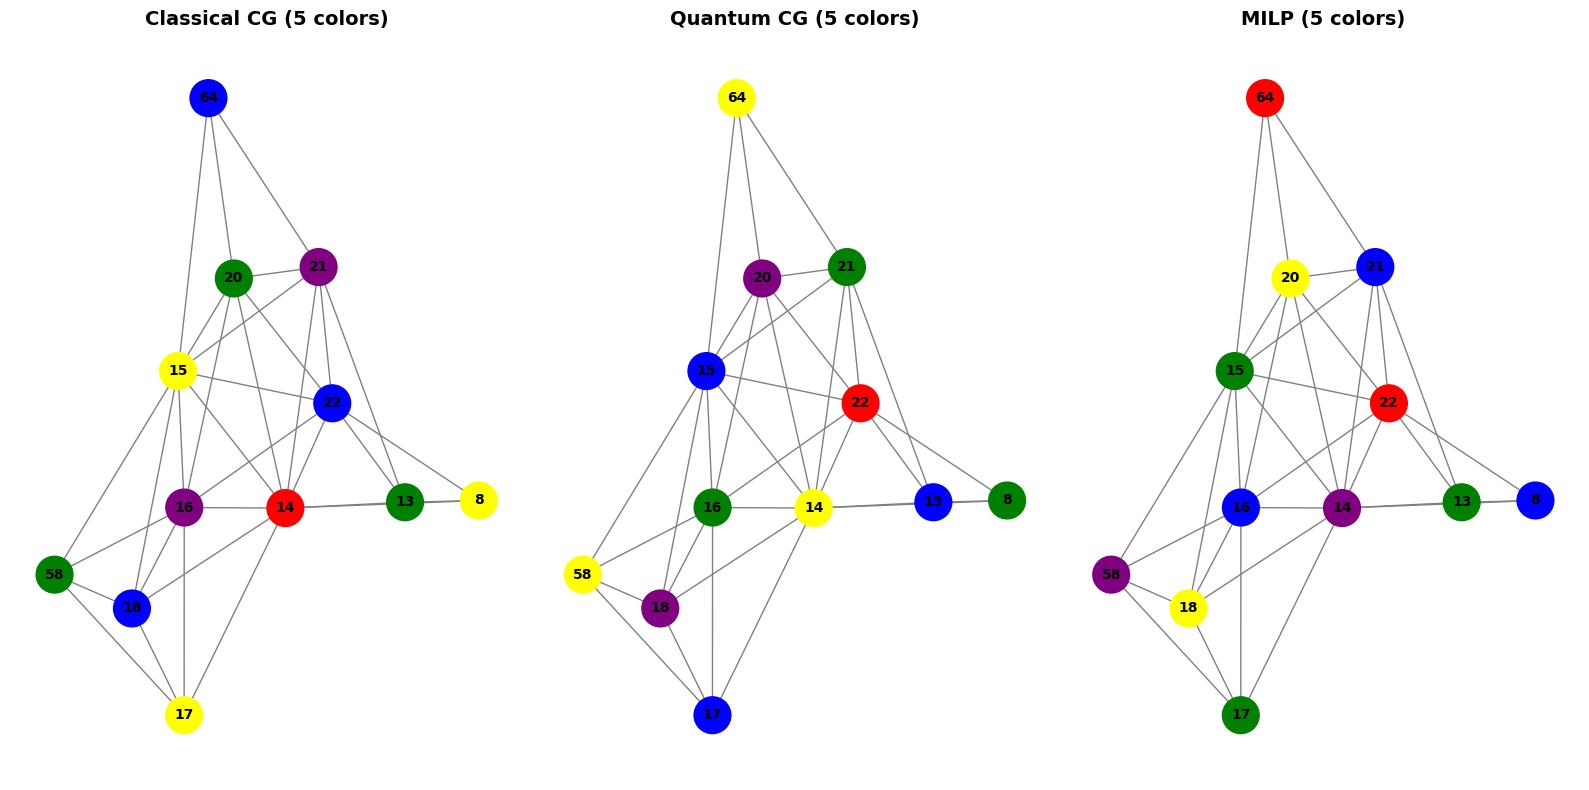

In [25]:
# Comprehensive comparison of all three methods
print("=" * 80)
print("COMPREHENSIVE ANTENNA FREQUENCY ASSIGNMENT COMPARISON")
print("=" * 80)

# Create a comparison table
methods_comparison = []

# Get results from previous sections
classical_valid = 'final_milp_res_c' in locals() and final_milp_res_c and final_milp_res_c.success
quantum_valid = 'final_milp_res' in locals() and final_milp_res and final_milp_res.success  
direct_valid = direct_milp_result and direct_milp_result.success

if classical_valid:
    classical_freq_count = len(classical_coloring)
    classical_status = "SUCCESS"
else:
    classical_freq_count = "FAILED"
    classical_status = "FAILED"

if quantum_valid:
    quantum_freq_count = len(quantum_coloring)
    quantum_status = "SUCCESS"
else:
    quantum_freq_count = "FAILED"
    quantum_status = "FAILED"

if direct_valid:
    direct_freq_count = len(direct_coloring)
    direct_status = "SUCCESS"
else:
    direct_freq_count = "FAILED"
    direct_status = "FAILED"

print(f"{'Method':<25} {'Status':<10} {'Frequencies':<12} {'Optimality':<15}")
print("-" * 70)
print(f"{'Classical Column Gen':<25} {classical_status:<10} {str(classical_freq_count):<12} {'Heuristic':<15}")
print(f"{'Quantum Column Gen':<25} {quantum_status:<10} {str(quantum_freq_count):<12} {'Heuristic':<15}")
print(f"{'Direct MILP':<25} {direct_status:<10} {str(direct_freq_count):<12} {'Optimal':<15}")

# Analysis and insights
print(f"\n{'='*80}")
print("ANALYSIS AND INSIGHTS")
print("="*80)

if direct_valid:
    optimal_frequencies = direct_freq_count
    print(f"Direct MILP provides the optimal solution: {optimal_frequencies} frequencies")
    
    if classical_valid:
        if classical_freq_count == optimal_frequencies:
            print(f"Classical Column Generation achieves optimality: {classical_freq_count} frequencies")
        else:
            subopt_gap = classical_freq_count - optimal_frequencies
            percentage = (subopt_gap / optimal_frequencies) * 100
            print(f"Classical Column Generation is suboptimal: {classical_freq_count} vs {optimal_frequencies} frequencies")
            print(f"Suboptimality gap: {subopt_gap} frequencies ({percentage:.1f}% above optimal)")
    
    if quantum_valid:
        if quantum_freq_count == optimal_frequencies:
            print(f"Quantum Column Generation achieves optimality: {quantum_freq_count} frequencies")
        else:
            subopt_gap = quantum_freq_count - optimal_frequencies
            percentage = (subopt_gap / optimal_frequencies) * 100
            print(f"Quantum Column Generation is suboptimal: {quantum_freq_count} vs {optimal_frequencies} frequencies")
            print(f"Suboptimality gap: {subopt_gap} frequencies ({percentage:.1f}% above optimal)")

# Create visualization comparison
if classical_valid and direct_valid:
    print(f"\n--- Creating Classical vs Direct MILP Visualization ---")
    # plot_classical_vs_direct_comparison(H, classical_coloring, direct_coloring, "Antenna Subgraph")
    plot_solution_comparison(H, classical_coloring, quantum_coloring, direct_coloring, "Antenna Subgraph")





### Key Lessons:

We have implemented the quantum column generation algorithm by Wesley da Silva Coelho et al. [2301.02637](https://arxiv.org/abs/2301.02637) to solve the graph coloring problem. The quantum solver can help speeding up the PMP problem in the coloumn generation routine. The `pulser` and `maximum-independent-set` module provide us tools to run and simulate the rydberg dynamics of the quantum routine. We invite the readers to play with different embedder and pulse setting to further optimize the routine.